# Prepare Data

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from skimage.color import rgb2gray
from sklearn import datasets, manifold
from sklearn.linear_model import LinearRegression
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error, r2_score
import sys

In [ ]:
def sample_spherical(npoints, ndim=3):
    X = np.random.randn(ndim, npoints)
    X /= np.linalg.norm(X, axis=0)
    X = X.T
    # filter = [not (x[2] > 0.9 or x[2] < -0.9 or (x[1] < 0 and x[0] > -0.2 and x[0] < 0.2)) for x in X]
    filter = [(x[2] < 0.7) for x in X]
    return X[filter]

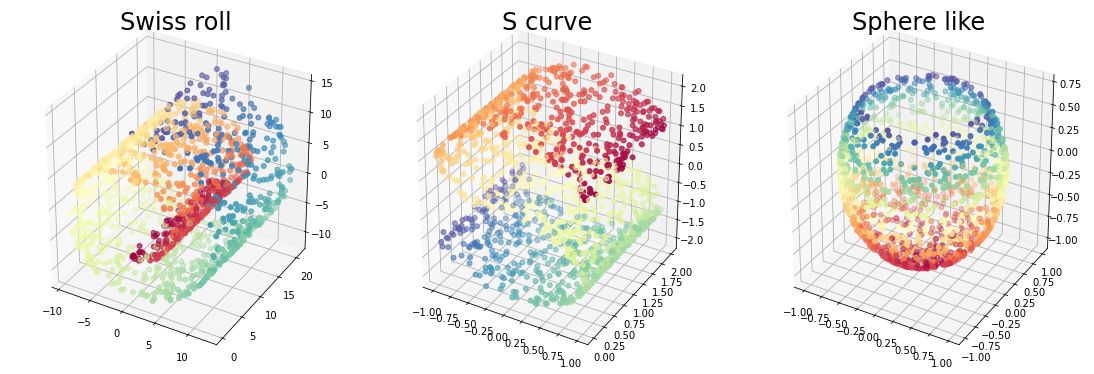

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 5)
# Swiss roll
X, color = datasets.make_swiss_roll(n_samples=1500, random_state=117)
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.scatter(X[:,0], X[:,1], X[:,2], c=color, cmap=plt.cm.Spectral, s=25)
plt.title("Swiss roll", fontsize=24)

# S curve
X, color =  datasets.make_s_curve(n_samples=1500, random_state=117)
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.scatter(X[:,0], X[:,1], X[:,2], c=color, cmap=plt.cm.Spectral, s=25)
plt.title("S curve", fontsize=24)

# Shpere
X = sample_spherical(1800)
color = X[:,2]
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.scatter(X[:,0], X[:,1], X[:,2], c=color, cmap=plt.cm.Spectral, s=25)
plt.title("Sphere like", fontsize=24)

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=1, 
                    wspace=0.1, 
                    hspace=0.3)
plt.show()

# Train model

In [ ]:
def LLE(k_set, X, color):
  fig = plt.figure()
  fig.set_size_inches(13, 8)

  for id, k in enumerate(k_set):
    embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=k, random_state=117)
    X_transformed = embedding.fit_transform(X)

    ax = fig.add_subplot(len(k_set) // 5 + (1 if len(k_set) % 5 else 0), 5, id + 1)
    ax.scatter(X_transformed[:,0], X_transformed[:,1], c=color, cmap=plt.cm.Spectral, s=25)

    plt.xticks([]), plt.yticks([])
    plt.title(f'k={k}', fontsize=20)

  plt.subplots_adjust(wspace=0.3, 
                      hspace=0.3)
  plt.show()

## Swiss roll n=1500

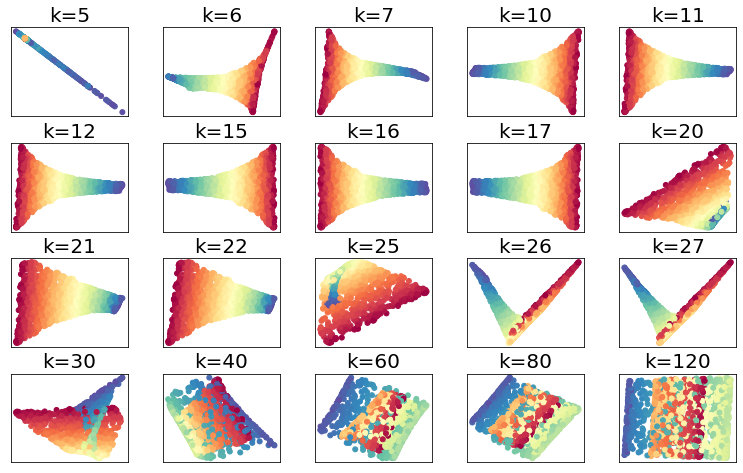

In [ ]:
X, color = datasets.make_swiss_roll(n_samples=1500, random_state=117)
k_set = [5, 6, 7, 10, 11, 12, 15, 16, 17, 20, 21, 22, 25, 26, 27, 30, 40, 60, 80, 120]

LLE(k_set, X, color)

## Swiss roll n=500

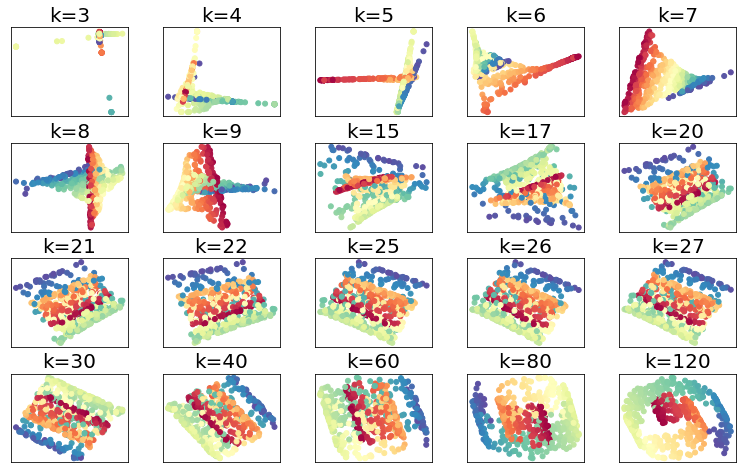

In [ ]:
X, color = datasets.make_swiss_roll(n_samples=500, random_state=117)
k_set = [3, 4, 5, 6, 7, 8, 9, 15, 17, 20, 21, 22, 25, 26, 27, 30, 40, 60, 80, 120]

LLE(k_set, X, color)

## S curve n=1500

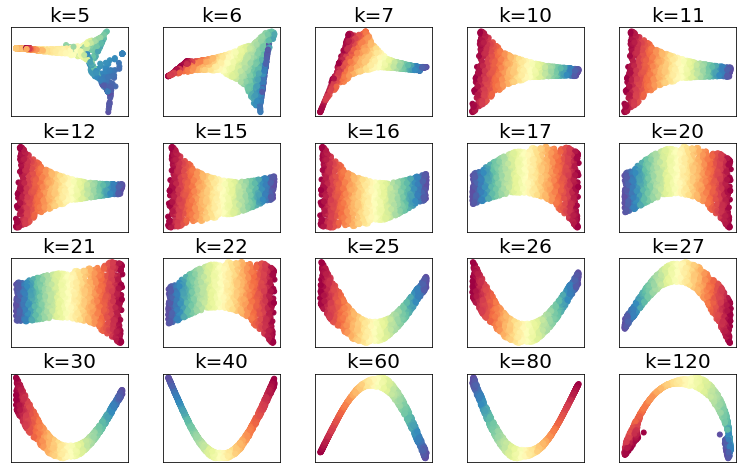

In [ ]:
X, color =  datasets.make_s_curve(n_samples=1500, random_state=117)
k_set = [5, 6, 7, 10, 11, 12, 15, 16, 17, 20, 21, 22, 25, 26, 27, 30, 40, 60, 80, 120]

LLE(k_set, X, color)

## Sphere n=1500

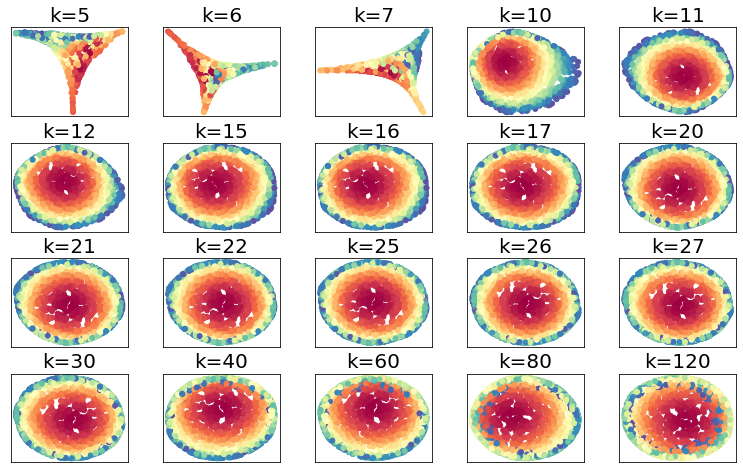

In [ ]:
X = sample_spherical(1800)
color = X[:,2]
k_set = [5, 6, 7, 10, 11, 12, 15, 16, 17, 20, 21, 22, 25, 26, 27, 30, 40, 60, 80, 120]

LLE(k_set, X, color)

# LLE using e-neighborhood

In [1]:
from sklearn.neighbors import radius_neighbors_graph

def locally_linear_embedding(X, eps, out_dim=2):
  G = radius_neighbors_graph(X, radius=eps, mode='distance')
  W = np.zeros((X.shape[0], X.shape[0]))

  for i, x in enumerate(X):
    Z = np.zeros((0, X.shape[1]))
    neighbor = []

    for ind in range(G.indptr[i], G.indptr[i+1]):
      neighbor.append(G.indices[ind])
      Z = np.vstack((Z, [X[G.indices[ind]]- x]))
    
    if not len(neighbor):
      raise Exception('eps is too small')

    # C = ZZ'
    
    C = Z @ Z.T
    _eps = 0.001 * np.trace(C)
    C = C + _eps * np.eye(C.shape[0])

    # c*w=1
    one = np.full((C.shape[0], 1), 1)
    w = np.linalg.solve(C, one)
    
    w /= np.sum(w)
    for id, wj in enumerate(w):
      W[i, neighbor[id]] = wj

  # M = (I-W)' (I-W)
  A = np.eye(W.shape[0]) - W
  A = A.T @ A

  eigen_values, eigen_vectors = np.linalg.eig(A)

  idx = eigen_values.argsort()
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]

  return eigen_vectors.T[1:out_dim + 1].T

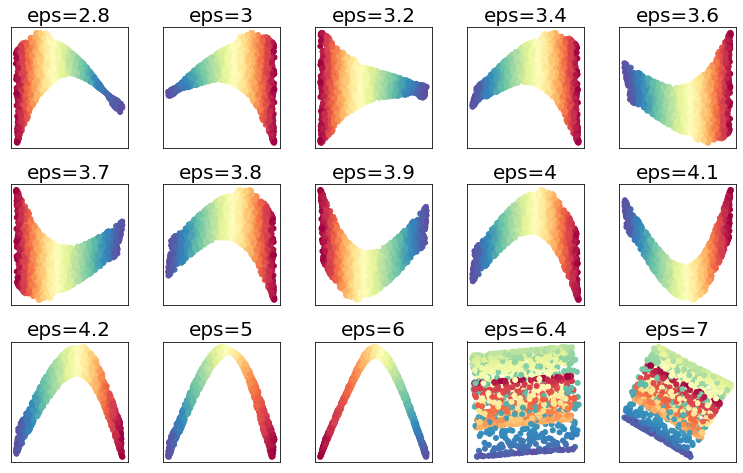

In [ ]:
import math
fig = plt.figure()
fig.set_size_inches(13, 8)
X, color = datasets.make_swiss_roll(n_samples=1500, random_state=117)
eps_set = [2.8, 3, 3.2, 3.4, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 5, 6, 6.4, 7]
# eps_set = [3.75, 4, 4.5, 4.6, 4.69, 4.7, 4.8, 4.9, 5, 5.6, 5.8, 6, 6.4, 7, 8]

for id, eps in enumerate(eps_set):
  X_transformed = locally_linear_embedding(X, eps, 2)

  ax = fig.add_subplot(len(eps_set) // 5 + (1 if len(eps_set) % 5 else 0), 5, id + 1)
  ax.scatter(X_transformed[:,0], X_transformed[:,1], c=color, cmap=plt.cm.Spectral, s=25)

  plt.xticks([]), plt.yticks([])
  plt.title(f'eps={eps}', fontsize=20)

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.3)
plt.show()

# Image compression

(427, 640)


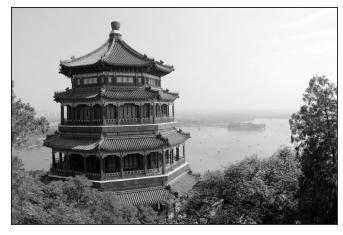

In [ ]:
image = datasets.load_sample_image("china.jpg")
grayscale = rgb2gray(image)
print(grayscale.shape)
plt.imshow(grayscale, cmap=plt.cm.gray)
plt.xticks([]), plt.yticks([])
plt.savefig("sample_image.png")
plt.show()

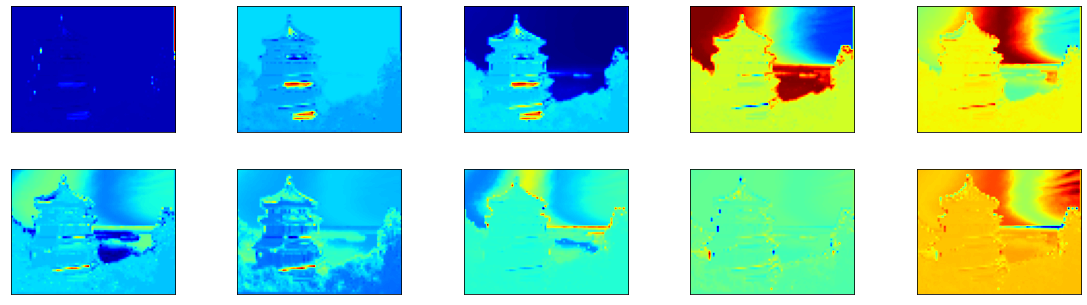

Compression rate: 0.17857142857142858


In [ ]:
def compress(image, height, width, slide_h, slide_w, feature):
  # add padding
  h, w = image.shape
  data = np.zeros((h + slide_h, w + slide_h))
  data[:h,:w] = image

  # split into patches
  patches = np.zeros((0, height * width))
  cur_h, cur_w = 0, 0
  cnt = 0
  while cur_h < h:
    while cur_w < w:
      patches = np.append(patches, [data[cur_h:cur_h + height, cur_w:cur_w + width].flatten().tolist()], axis=0)
      cur_w += slide_w
    cnt += 1
    cur_h += slide_h
    cur_w = 0

  # compress using LLE
  embedding = LocallyLinearEmbedding(n_components=feature, n_neighbors=15, random_state=117)
  Y = embedding.fit_transform(patches).T

  # show heatmaps
  fig = plt.figure()
  fig.set_size_inches(15, 4)

  for i in range(feature):
    ax = fig.add_subplot(2 + feature % 2, feature//2, i+1)
    ax.imshow(Y[i].reshape((cnt, Y[i].shape[0] // cnt)), cmap='jet')
    plt.xticks([]), plt.yticks([])

  plt.subplots_adjust(left=0,
                      bottom=0, 
                      right=1, 
                      top=1, 
                      wspace=0.3, 
                      hspace=0.3)
  plt.show()

  # Calculate compression rate
  rate = Y.shape[0] * Y.shape[1] / (image.shape[0] * image.shape[1])
  print(f'Compression rate: {rate}')

  return patches, Y.T

patches, Y = compress(grayscale, 10, 10, 7, 8, 10)

In [ ]:
reg = LinearRegression().fit(Y, patches)
_patches = reg.predict(Y)
print('Mean squared error: %.6f' % mean_squared_error(patches, _patches))
print('Coefficient of determination: %.6f' % r2_score(patches, _patches))

Mean squared error: 0.013812
Coefficient of determination: 0.871425
